<font size="5"><center> **Exercise 2 (From numbers to words)** </center></font>
<font size="4"><center> CS-673 <br> Introduction to Deep Generative Models </center></font>
<font size="4"><center> Sifakis Emmanouil, *1288* </center></font>

---

↓ Imports ↓

In [ ]:
!pip install num2words

In [ ]:
# Imports
from num2words import num2words
import random
import numpy as np
import pandas as pd
import re
import difflib
# networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
# transformers
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
# plots
import matplotlib.pyplot as plt

In [ ]:
def generate_dataset(size, max_num):
    dataset = []
    for _ in range(size):
        number = str(random.randint(1, max_num))
        sentence = num2words(int(number), lang='en').replace('-', ' ').replace(',', '')  # remove dashes and commas
        # sentence = ' '.join([word for word in sentence.split() if word != 'and'])  # Remove 'and'
        dataset.append((number, sentence))
    return dataset

def find_voc(dataset):
    unique_words = set()
    for _, sentence in dataset:
        unique_words.update(sentence.split())
    return list(unique_words)

class NumberWordDataset(Dataset):
    def __init__(self, dataset, vocab):
        self.dataset = dataset
        self.vocab = vocab
        self.word_to_idx = {word: i for i, word in enumerate(vocab)}
        self.max_words = max(len(sentence.split()) for _, sentence in dataset)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        _, sentence = self.dataset[idx]
        word_indices = [self.word_to_idx[word] for word in sentence.split()]
        word_indices_padded = self.left_zero_pad_indices(word_indices)
        return torch.tensor(word_indices_padded), len(word_indices)

    def left_zero_pad_indices(self, indices):
        padded_indices = indices + [0] * (self.max_words - len(indices))
        return padded_indices


# Generate the Dataset
dataset_size = 10**5
max_number = 10**9
dataset = generate_dataset(dataset_size, max_number)

# Define Parameters
VOCABULARY = find_voc(dataset)
BATCH_SIZE = 64

# Process the dataset and Cretae dataloader for the network
number_dataset = NumberWordDataset(dataset, VOCABULARY)
dataloader = DataLoader(number_dataset, batch_size= BATCH_SIZE, shuffle=True)


### Implement and then train a GRU

In [ ]:
class N2W_GRU(nn.Module):
    def __init__(self, hidden_dim, embedding_dim, vocab_size):
        super(N2W_GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x):
        emb = self.embedding(x)
        gru_out, _ = self.gru(emb)
        out = self.fc(gru_out)
        return out

Epoch 1, Average Loss: 1.307321515360934
Epoch 2, Average Loss: 0.13319775618026444
Epoch 3, Average Loss: 0.03283418875106599
Epoch 4, Average Loss: 0.011519294127557362
Epoch 5, Average Loss: 0.004793017845534107
Epoch 6, Average Loss: 0.0021175182971481282
Epoch 7, Average Loss: 0.0009568317965027874
Epoch 8, Average Loss: 0.000434520798130527
Epoch 9, Average Loss: 0.00019827149870971686
Epoch 10, Average Loss: 9.147030650358737e-05


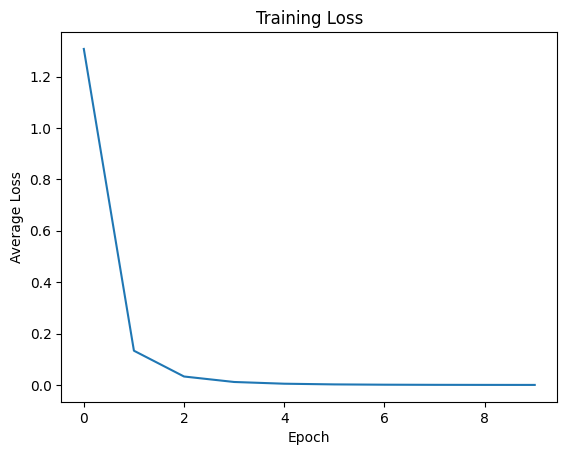

In [ ]:
# Initialization
LEARNING_RATE = 1e-5
NUM_EPOCHS = 10
EMBEDDING_SIZE = 256
HIDDEN_SIZE = 256

# Main and Training
model = N2W_GRU(HIDDEN_SIZE, EMBEDDING_SIZE, len(VOCABULARY))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def train_and_plot_losses(dataloader, model, criterion, optimizer, num_epochs):
    total_losses = []
    for epoch in range(num_epochs):
        epoch_losses = []
        for words, _ in dataloader:
            optimizer.zero_grad()
            output = model(words)
            loss = criterion(output.transpose(1, 2), words)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        # Calculate and store the average loss for the epoch
        epoch_loss_avg = sum(epoch_losses) / len(epoch_losses)
        total_losses.append(epoch_loss_avg)
        # Print the average loss for the epoch
        print(f"Epoch {epoch + 1}, Average Loss: {epoch_loss_avg}")

    # Plot the losses
    plt.plot(total_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss')
    plt.show()

    return total_losses

losses = train_and_plot_losses(dataloader, model, criterion, optimizer, NUM_EPOCHS)

### Generation

In [ ]:
def find_closest_word(word, vocab):
    closest_word = difflib.get_close_matches(word, vocab, n=1)
    if closest_word:
        return closest_word[0]
    else:
        return None

def generate_word_representation(model, number, vocab, mod):
    # Tokenize the number and pad/truncate it to match the model's input size
    number_words = num2words(number, lang='en').replace('-', ' ').replace(',', '').split()
    cleaned_output = ' '.join(number_words)

    number_indices = []
    for word in number_words:
        if word in vocab:
            number_indices.append(vocab.index(word))
        else:
            closest_word = find_closest_word(word, vocab)
            if closest_word is not None:
                number_indices.append(vocab.index(closest_word))

    # maximum input size based on the embedding size
    max_input_size = model.embedding.weight.shape[0]
    # number of tokens > maximum input size ==> truncate
    if len(number_indices) > max_input_size:
        number_indices = number_indices[:max_input_size]
    # number of tokens <  maximum input size ==> pad it with zeros
    elif len(number_indices) < max_input_size:
        number_indices += [0] * (max_input_size - len(number_indices))

    input_tensor = torch.tensor(number_indices).unsqueeze(0)  # Add batch dimension

    # Pass through the model
    with torch.no_grad():
        output = model(input_tensor)

    if mod == 'transformer':
        # Get the indices of the highest probability words
        _, predicted_indices = torch.max(output, dim=2)
        predicted_indices = predicted_indices.squeeze().tolist()

        # indices to words
        predicted_words = [vocab[idx] for idx in predicted_indices if idx != 0]  # Remove padding
        model_output = ' '.join(predicted_words)
    elif mod == 'gru':
        # Sample from the output distribution
        sampled_indices = torch.multinomial(F.softmax(output, dim=2).squeeze(0), 1)
        sampled_indices = sampled_indices.squeeze().tolist()

        # indices to words
        sampled_words = [vocab[idx] for idx in sampled_indices if idx != 0]  # Remove padding
        model_output = ' '.join(sampled_words)

    # Calculate accuracy
    accuracy = difflib.SequenceMatcher(None, cleaned_output, model_output).ratio()

    return model_output, accuracy


### Example of word generation for numbers in the training range $1-10^9$

In [ ]:
# Generate 100 random numbers
total_numbers = 100
random_numbers = [random.randint(1, 10**9) for _ in range(total_numbers)]

# Obtain word representations for each number
print("~~~ Word Representation ~~~\n")
accuracy_list = []
for number in random_numbers:
    word_representation, accuracy = generate_word_representation(model, number, VOCABULARY, 'gru')
    accuracy_list.append(accuracy)
    print(f"{number} / accuracy:{accuracy}\n==> {word_representation}")
    print(f"accuracy==> {accuracy}")


~~~ Word Representation ~~~

789632944 / accuracy:1.0
==> seven hundred and eighty nine million six hundred and thirty two thousand nine hundred and forty four
accuracy==> 1.0
621888892 / accuracy:1.0
==> six hundred and twenty one million eight hundred and eighty eight thousand eight hundred and ninety two
accuracy==> 1.0
348674127 / accuracy:1.0
==> three hundred and forty eight million six hundred and seventy four thousand one hundred and twenty seven
accuracy==> 1.0
569595016 / accuracy:1.0
==> five hundred and sixty nine million five hundred and ninety five thousand and sixteen
accuracy==> 1.0
881121606 / accuracy:1.0
==> eight hundred and eighty one million one hundred and twenty one thousand six hundred and six
accuracy==> 1.0
785285125 / accuracy:1.0
==> seven hundred and eighty five million two hundred and eighty five thousand one hundred and twenty five
accuracy==> 1.0
28563544 / accuracy:1.0
==> twenty eight million five hundred and sixty three thousand five hundred and fort

#### Avarage Accuracy of word generation for numbers in the training range

In [ ]:
generate_acc = np.mean(accuracy_list)
print(f"Mean Accuracy of generating {total_numbers}: {generate_acc:.5f}")

Mean Accuracy of generating 100: 0.99721


### Example of word generation for numbers out of the training range $10^{10}-10^{15}$

In [ ]:
# Generate 20 random numbers
total_numbers = 100
random_numbers = [random.randint(10**10, 10**15) for _ in range(total_numbers)]

# Obtain word representations for each number
print("~~~ Word Representation ~~~\n")
accuracy_list = []
for number in random_numbers:
    word_representation, accuracy = generate_word_representation(model, number, VOCABULARY, 'gru')
    accuracy_list.append(accuracy)
    print(f"{number} / accuracy:{accuracy}\n==> {word_representation}")
    print(f"accuracy==> {accuracy}")

~~~ Word Representation ~~~

204063168591786 / accuracy:0.9833887043189369
==> two hundred and four million sixty three million one hundred and sixty eight million five hundred and ninety one thousand seven hundred and eighty six
accuracy==> 0.9833887043189369
752016092469425 / accuracy:0.9816849816849816
==> seven hundred and fifty two million sixteen million ninety two million four hundred and sixty nine thousand four hundred and twenty five
accuracy==> 0.9816849816849816
74461784262384 / accuracy:0.9842271293375394
==> seventy four million four hundred and sixty one million seven hundred and eighty four million two hundred and sixty two thousand three hundred and eighty four
accuracy==> 0.9842271293375394
196395951592203 / accuracy:0.984984984984985
==> one hundred and ninety six million three hundred and ninety five million nine hundred and fifty one million five hundred and ninety two thousand two hundred and three
accuracy==> 0.984984984984985
478051397893444 / accuracy:0.9847094

#### Avarage Accuracy of word generation for numbers out of the training range $10^{10}-10^{15}$

In [ ]:
generate_acc = np.mean(accuracy_list)
print(f"Mean Accuracy of generating {total_numbers}: {generate_acc:.5f}")

Mean Accuracy of generating 100: 0.98318


---

### Implement and then train a TRANSFORMER

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1, Average Loss: 0.35941346453041584
Epoch 2, Average Loss: 0.010971557353733445
Epoch 3, Average Loss: 0.003839283485039449
Epoch 4, Average Loss: 0.0017489022611070159
Epoch 5, Average Loss: 0.0008584997162070324
Epoch 6, Average Loss: 0.000428054950180507
Epoch 7, Average Loss: 0.00021233498272064464
Epoch 8, Average Loss: 0.0001041671471630869
Epoch 9, Average Loss: 5.058791599182355e-05
Epoch 10, Average Loss: 2.435352527762877e-05


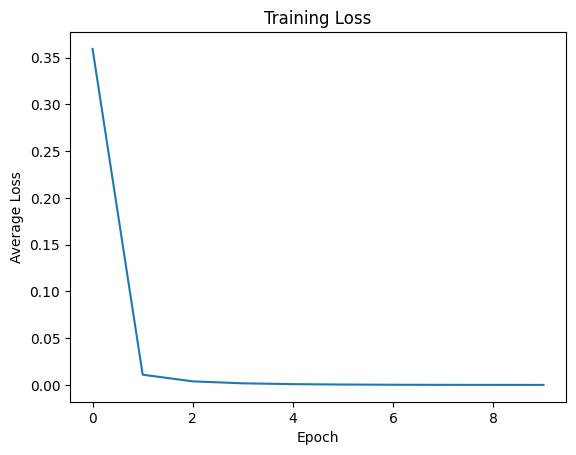

In [ ]:
class N2W_Transformer(nn.Module):
    def __init__(self, hidden_dim, embedding_dim, vocab_size, num_layers=6, dropout=0.1):
        super(N2W_Transformer, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        encoder_layers = TransformerEncoderLayer(embedding_dim, nhead=8, dim_feedforward=hidden_dim, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, vocab_size)

    def forward(self, x):
        emb = self.embedding(x)
        emb = emb.permute(1, 0, 2)  # Transformer expects batch first
        transformer_out = self.transformer_encoder(emb)
        out = self.fc(transformer_out)
        return out

# Adjust initialization
NUM_LAYERS = 6
DROPOUT = 0.1

# Main and Training
transformer_model = N2W_Transformer(HIDDEN_SIZE, EMBEDDING_SIZE, len(VOCABULARY), num_layers=NUM_LAYERS, dropout=DROPOUT)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=LEARNING_RATE)

def train_and_plot_losses_transformer(dataloader, model, criterion, optimizer, num_epochs):
    total_losses = []
    for epoch in range(num_epochs):
        epoch_losses = []
        for words, _ in dataloader:
            optimizer.zero_grad()
            output = model(words)
            # The output shape of Transformer is (seq_len, batch_size, vocab_size)
            # We need to permute it to match the target shape for CrossEntropyLoss
            output = output.permute(1, 2, 0)
            loss = criterion(output, words)
            loss.backward()
            optimizer.step()
            epoch_losses.append(loss.item())
        epoch_loss_avg = sum(epoch_losses) / len(epoch_losses)
        total_losses.append(epoch_loss_avg)
        print(f"Epoch {epoch + 1}, Average Loss: {epoch_loss_avg}")

    plt.plot(total_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.title('Training Loss')
    plt.show()

    return total_losses

losses_transformer = train_and_plot_losses_transformer(dataloader, transformer_model, criterion, optimizer, NUM_EPOCHS)


### Example of word generation for numbers in the training range $1-10^{9}$

In [ ]:
# Generate 20 random numbers including one outside the training range
total_numbers = 20
random_numbers = [random.randint(1, 10**9) for _ in range(total_numbers)]

# Obtain word representations for each number
print("~~~ Word Representation ~~~\n")
accuracy_list = []
for number in random_numbers:
    # Check if the number is within the training range
    word_representation, accuracy = generate_word_representation(transformer_model, number, VOCABULARY, 'transformer')
    accuracy_list.append(accuracy)
    print(f"{number} / accuracy:{accuracy}\n==> {word_representation}")


~~~ Word Representation ~~~

427313681 / accuracy:0.9795918367346939
==> four hundred and twenty seven million three hundred and thirteen thousand hundred and eighty one
553641310 / accuracy:0.978021978021978
==> five hundred and fifty three million hundred and forty one thousand three hundred and ten
559394370 / accuracy:1.0
==> five hundred and fifty nine million three hundred and ninety four thousand three hundred and seventy
196038195 / accuracy:0.975609756097561
==> one hundred and ninety million thirty eight thousand one hundred and ninety five
583427192 / accuracy:1.0
==> five hundred and eighty three million four hundred and twenty seven thousand one hundred and ninety two
992543173 / accuracy:1.0
==> nine hundred and ninety two million five hundred and forty three thousand one hundred and seventy three
446611609 / accuracy:0.9259259259259259
==> four hundred and forty million hundred and eleven thousand hundred and nine
172428708 / accuracy:1.0
==> one hundred and seventy two 

#### Avarage Accuracy of word generation for numbers in the training range $1-10^{9}$

In [ ]:
generate_acc = np.mean(accuracy_list)
print(f"Mean Accuracy of generating {total_numbers}: {generate_acc:.5f}")

Mean Accuracy of generating 20: 0.98769


### Example of word generation for numbers out of the training range $10^{10}-10^{15}$

In [ ]:
# Generate 20 random numbers including one outside the training range
total_numbers = 20
random_numbers = [random.randint(10**10, 10**15) for _ in range(total_numbers)]

# Obtain word representations for each number
print("~~~ Word Representation ~~~\n")
accuracy_list = []
for number in random_numbers:
    # Check if the number is within the training range
    word_representation, accuracy = generate_word_representation(transformer_model, number, VOCABULARY, 'transformer')
    accuracy_list.append(accuracy)
    print(f"{number} / accuracy:{accuracy}\n==> {word_representation}")

~~~ Word Representation ~~~

898653141105424 / accuracy:0.972809667673716
==> eight hundred and ninety eight million hundred and fifty three million one hundred and forty one million one hundred and five thousand four hundred and twenty four
918310429224293 / accuracy:0.984984984984985
==> nine hundred and eighteen million three hundred and ten million four hundred and twenty nine million two hundred and twenty four thousand two hundred and ninety three
960675118778912 / accuracy:0.9724770642201835
==> nine hundred and sixty million hundred and seventy five million one hundred and eighteen million seven hundred and seventy eight thousand nine hundred and twelve
928641597504435 / accuracy:0.9731343283582089
==> nine hundred and twenty eight million hundred and forty one million five hundred and ninety seven million five hundred and four thousand four hundred and thirty five
777726886730958 / accuracy:0.9623188405797102
==> seven hundred and seventy seven million seven hundred and twenty

#### Avarage Accuracy of word generation for numbers out of the training range $10^{10}-10^{15}$

In [ ]:
generate_acc = np.mean(accuracy_list)
print(f"Mean Accuracy of generating {total_numbers}: {generate_acc:.5f}")

Mean Accuracy of generating 20: 0.96900
